In [25]:
import polars.selectors as cs
import numpy as np

import polars as pl
import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


In [26]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    10: ['c_custkey', 'c_name', 'c_acctbal', 'c_phone', 'n_name', 'c_address', 'c_comment'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([1,4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [27]:
q4_dp = {'1-URGENT': [1.5117655067070224,
  1.115290282381145,
  0.7414847472302021,
  0.5489781539940463,
  0.34369734869085405,
  0.24392194927991181,
  0.12891642215037355,
  0.034509951755375586,
  0.03511694188227311,
  0.03385139722675703],
 '2-HIGH': [1.5615131295829283,
  1.1283322721241278,
  0.7869071968315171,
  0.5691955181549209,
  0.3396626050588161,
  0.24000093904196476,
  0.135181560418701,
  0.035620465325025864,
  0.032255149506921814,
  0.03304783864981104],
 '3-MEDIUM': [1.5970726029871707,
  1.094754508313955,
  0.7762963838867764,
  0.5423074820289068,
  0.37157672710086875,
  0.2444211453605979,
  0.13542448684983685,
  0.035580745643532155,
  0.033952413847819905,
  0.033380166471294534],
 '4-NOT SPECIFIED': [1.5764544844432136,
  1.0976042053963153,
  0.7474603539126871,
  0.5285064716433713,
  0.3625636372348437,
  0.2354498836969627,
  0.1310023308391933,
  0.03344792046913564,
  0.03340256504894011,
  0.033838586047816185],
 '5-LOW': [1.587168367650374,
  1.0513520088894168,
  0.7768863355598147,
  0.5715867094598752,
  0.3826118158928961,
  0.24457649466849807,
  0.13770691008222954,
  0.03289781425590712,
  0.03523690608037226,
  0.034628714269366666]}

In [34]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15,8), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range
    global_handles = []
    global_labels = []
    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
#                 print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    print(flag, status, y.to_list())
                    line = ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        linewidth=3)[0]
                    if row == 0 and col_idx==0:
                        print(flag, status)
                        global_handles.append(line)
                        global_labels.append(line.get_label())
#         assert(False)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative\nError (%)', fontsize=15)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=20)
#         ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)

    fig.legend(
        handles=global_handles,
        labels=global_labels,
        loc='lower center',
        ncol=4,  # tweak columns as you like
        fontsize=14,
        frameon=False
    )
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)

    plt.savefig('../figs/q1_results.png')

In [35]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=20)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figs/q14_results.png')

In [36]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', linewidth=3,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)


        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figs/q12_results.png')

In [37]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

In [38]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', linewidth=3)
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', linewidth=3)

        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 1:
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating Order Count Difference % ({labels[i]})', fontsize=18)
        ax.grid(True, alpha=0.3)
        plt.subplots_adjust(hspace=1.0)  # hspace controls vertical spacing
    handles, labels_legend = axes[0].get_legend_handles_labels()
#         fig.legend(handles, labels_legend, bbox_to_anchor=(0.5, -0.01), 
#                   loc='upper center', ncol=3, fontsize=16)
    fig.legend(handles, labels_legend,
               loc='lower center', ncol=3, fontsize=14)

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.3)
    plt.savefig('../figs/q4_results.png', bbox_inches='tight')

Q1
A F [2.2135389902879887, 1.6122148088890371, 1.1285702952062693, 0.861191244574634, 0.6369962811075089, 0.46689278225016667, 0.37747332065821604, 0.352068594558299, 0.3159473247075696, 0.3101189033737884]
A F
N F [4.861029716374153, 3.3347415530165594, 2.500944462696608, 1.7945322491334692, 1.3118106495837136, 1.0805371860953954, 0.8717819791952028, 0.7368846845089686, 0.6640713299680933, 0.6569696343217215]
N F
N O [2.10726077141116, 1.4374320068465258, 1.0608402209786723, 0.7905800607967008, 0.5705230633188183, 0.446278697897387, 0.3394625109183822, 0.3067660960767272, 0.2853360080543613, 0.27592100340520015]
N O
R F [2.2316942560295345, 1.5629413484322385, 1.0925424951251763, 0.8396846004066192, 0.6134353238578599, 0.4724000964738561, 0.4029138996773435, 0.3541746853818141, 0.3007185841285349, 0.29810339221927773]
R F
A F [0.3026656162724648, 0.22668715302727757, 0.15089199498072284, 0.11741157646186882, 0.08661704335960604, 0.06789141747031667, 0.05583314417944854, 0.04907763434

Q12
priority
[9.083836494291885, 6.355505127132082, 4.809839897501349, 3.3903237755487923, 2.5375188336619, 2.0583037886844977, 1.6447219802057043, 1.4017010068088613, 1.3094644088263807, 1.2057312928414812]
priority
[8.99086084653137, 6.5760457147430404, 4.611649491456246, 3.339722141760021, 2.54289415938942, 1.932628022260622, 1.5691272412066966, 1.2980486091989696, 1.218914534988702, 1.2283514803907647]
priority
[7.534704753530923, 5.282416680172009, 3.7381929246755408, 2.8049249681635855, 2.1181704031034316, 1.5932992263768875, 1.2868204640519993, 1.1129843409278941, 0.9982238888958314, 0.9937896882406485]
priority
[6.801905267093764, 5.352132864635992, 3.7641535799685766, 2.666425278801143, 2.0753276825108897, 1.61009684615914, 1.3361721588123032, 1.0937458315119701, 1.0792052817596092, 0.9779140334934222]
Q14!
[5.480779852311625, 4.1217527357010795, 2.7369918943191647, 2.0583587986616276, 1.5230460978308493, 1.1733365591514597, 0.9873174662702712, 0.8628212435798418, 0.7857511580

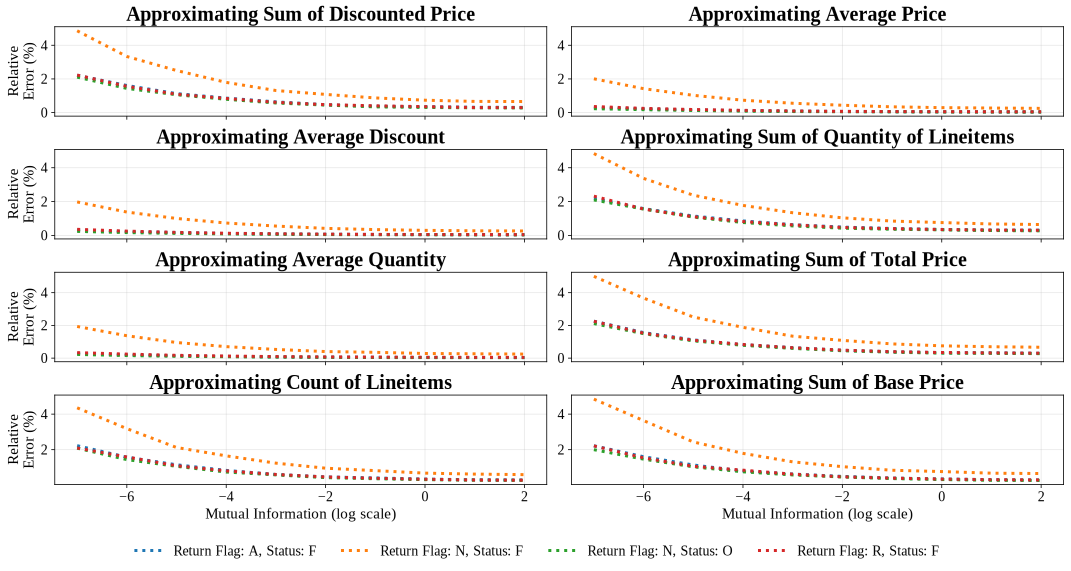

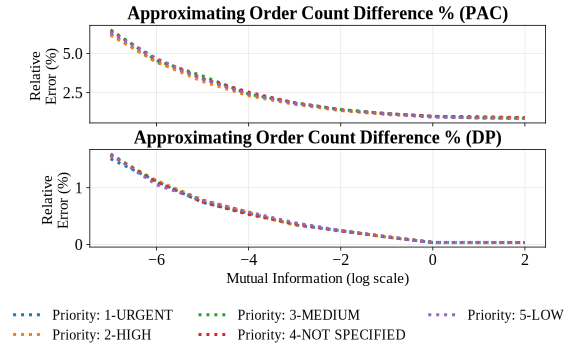

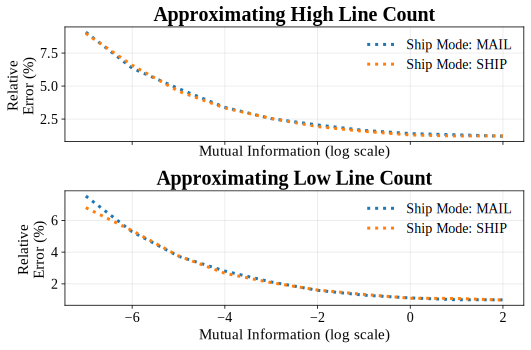

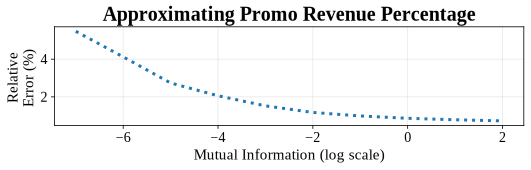

In [39]:
for query_ind in [1, 4, 12, 14]:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        if query_ind == 10:
            orig = orig.select(
                pl.col("c_custkey"), pl.col("c_name"),
                pl.col("c_acctbal").cast(str),
                pl.col("n_name"), pl.col("c_address"), pl.col("c_phone"), pl.col("c_comment")
            )
        noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                        if query_ind == 1 and not (base_name[:3] == 'sum' or base_name[:5] == 'count'):
                            const = 1 # remove for parts of q1
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    noised_vals = [merged_df[noised][ind][tmp_ind] for tmp_ind in range(
                        len(merged_df[noised][ind])) if merged_df[noised][ind][tmp_ind] is not None]
#                     print(merged_df[noised])
                    new = np.average(
                        [100*abs(
                            const*noised_vals[tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(noised_vals))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
    graph_query(full_df, query_ind)

In [127]:
merged_df

o_orderpriority,order_count,order_count_noised,pct_diff_order_count,mi
str,i64,list[f64],f64,f64
"""1-URGENT""",10594,"[5266.391624, 5389.871969, … 5317.589149]",0.882427,4.0
"""2-HIGH""",10476,"[5305.490389, 5290.92307, … 5290.600761]",0.889573,4.0
"""3-MEDIUM""",10410,"[5265.119447, 5222.427438, … 5211.3311]",0.895078,4.0
"""4-NOT SPECIFIED""",10556,"[5322.628131, 5211.98052, … 5219.405857]",0.943575,4.0
"""5-LOW""",10487,"[5242.821465, 5204.67178, … 5288.247188]",0.906205,4.0


In [41]:
d1 = {1: 0.780235840412426,
 4: 2.4221572815994117,
 5: 8.6342485825638,
 6: 1.2066066134348221,
 7: 8.327955249732529,
 8: 37.54781394621588,
 9: 7.168851719295008,
 12: 2.941192858272344,
 13: 11.095915070243906,
 14: 2.2765135934336995,
 15: 35.032376010417956,
 17: 10.626290816892377,
 19: 24.532566038505866,
 21: 63.900945213999414,
 22: 7.908884275019332}
avg_errors = {
    "Q2": 0.,
    "Q5": 8.6342485825638,
    "Q6": 1.2066066134348221,
    "Q7": 8.327955249732529,
    "Q8": 37.54781394621588,
    "Q9":  7.168851719295008,
    "Q11": 0.,
    "Q12": 2.941192858272344,
    "Q13": 11.095915070243906,
    "Q15": 35.032376010417956,
    "Q16": 0.,
    "Q17": 10.626290816892377,
    "Q19": 24.532566038505866,
    "Q21": 63.900945213999414,
    "Q22": 7.908884275019332}

d2 = {1: 0.7556880802111988,
 4: 2.4040037081433274,
 5: 8.854581686905387,
 6: 1.1866798958039402,
 7: 8.780564309520603,
 8: 35.54604282613709,
 9: 7.068615806325052,
 12: 3.0503490410683853,
 13: 10.854701901760366,
 14: 2.0583587986616276,
 15: 35.747335576100014,
 17: 11.474393040914164,
 19: 24.275938584227244,
 21: 63.8807483675156,
 22: 7.744830183693608}

avg_errors_128 = {'Q2': 0,
 'Q5': 8.854581686905387,
 'Q6': 1.1866798958039402,
 'Q7': 8.780564309520603,
 'Q8': 35.54604282613709,
 'Q9': 7.068615806325052,
 'Q11': 0,
 'Q12': 3.0503490410683853,
 'Q13': 10.854701901760366,
 'Q15': 35.747335576100014,
 'Q17': 11.474393040914164,
 'Q19': 24.275938584227244,
 'Q21': 63.8807483675156,
 'Q22': 7.744830183693608}

# {1: 0.0,
#  3: 100.0,
#  4: 0.0,
#  5: 0.0,
#  6: 0.0,
#  7: 0.0,
#  8: 0.0,
#  9: 0.0,
#  12: 0.0,
#  13: 11.904761904761905,
#  14: 0.0,
#  15: 0.0,
#  17: 0.0,
#  19: 0.0,
#  21: 8.0,
#  22: 0.0}
null_pct = {
    "Q3": 100,
    "Q13": 11.904761904761905,
    "Q10": 100,
    "Q18": 100,
    "Q21": 8.
}

# {1: 0.0,
#  3: 100.0,
#  4: 0.0,
#  5: 0.0,
#  6: 0.0,
#  7: 0.0,
#  8: 0.0,
#  9: 0.0,
#  12: 0.0,
#  13: 11.904761904761905,
#  14: 0.0,
#  15: 0.0,
#  17: 0.0,
#  19: 0.0,
#  21: 1.0,
#  22: 0.0}

null_pct_128 = {
    "Q3": 100,
    "Q13": 11.904761904761905,
    "Q10": 100,
    "Q18": 100,
    "Q21": 1.0
}

In [44]:
max_diff = 0.
max_key = None
for k in d1:
    assert k in d2
    if abs(d1[k] - d2[k]) > max_diff:
        max_diff = abs(d1[k] - d2[k])
        max_key = k
max_key, max_diff

(8, 2.001771120078793)

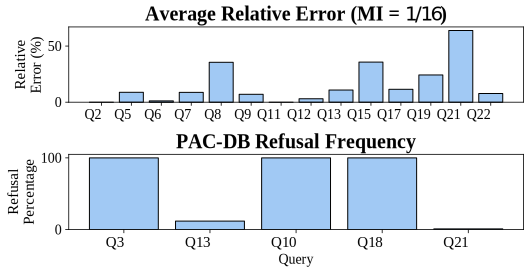

In [24]:
# Create the bar plot for unnoised times
import matplotlib as mpl
import matplotlib_inline.backend_inline

mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 4))

error_keys = avg_errors_128.keys()
error_vals = avg_errors_128.values()
ax1.bar(error_keys, error_vals, color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax1.set_xticks(x, error_keys, ha='right', fontsize=14)
# ax1.set_xlabel('Query', fontsize=16)
ax1.set_ylabel('Relative\nError (%)', fontsize=15)
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax1.set_title("Average Relative Error (MI = $1/16$)", fontsize=20)


error_keys = null_pct_128.keys()
error_vals = null_pct_128.values()
ax2.bar(error_keys, error_vals,color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax2.set_xticks(x, error_keys, ha='right', fontsize=15)
ax2.set_xlabel('Query', fontsize=14)
ax2.set_ylabel('Refusal\nPercentage', fontsize=15)
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax2.set_title("PAC-DB Refusal Frequency", fontsize=20)

plt.subplots_adjust(hspace=0.5)  # Add padding between plots
plt.tight_layout()
plt.savefig('../figs/overall_utility.png')